In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime 
from matplotlib.dates import MonthLocator, DateFormatter
from utilities import filterout, normalize,get_common_dates
import seaborn as sns
import scipy.stats as stats
sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(8, 8))
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
from scipy.optimize import brentq, fsolve
from statsmodels.distributions.copula.api import (CopulaDistribution, \
                GumbelCopula, StudentTCopula, ClaytonCopula,FrankCopula)
#import QuantLib as ql

In [2]:
filenames = [ "IG","HY","SPX"]

# Store each series in a mapping from filename to dataframe
dfs = {
    fn: pd.read_csv(f"{fn}.csv", parse_dates=["Date"]) for fn in filenames
}
# Get the intersection of the time series data relative to common dates
date_index = get_common_dates(dfs,filenames)
common_date_dfs = {
    fn: dfs[fn][date_index[fn]] for fn in filenames
}
# Set the index of the dataframes to be the dates
for key in common_date_dfs.keys():
    common_date_dfs[key] = common_date_dfs[key].set_index("Date")
    
# Normalized time series
normalized_series = {
    fn: normalize(common_date_dfs[fn][fn]) for fn in filenames
}

#convert date into stationary series
stationary_series = {
    fn:np.diff(np.log(common_date_dfs[fn][fn])) for fn in filenames
}


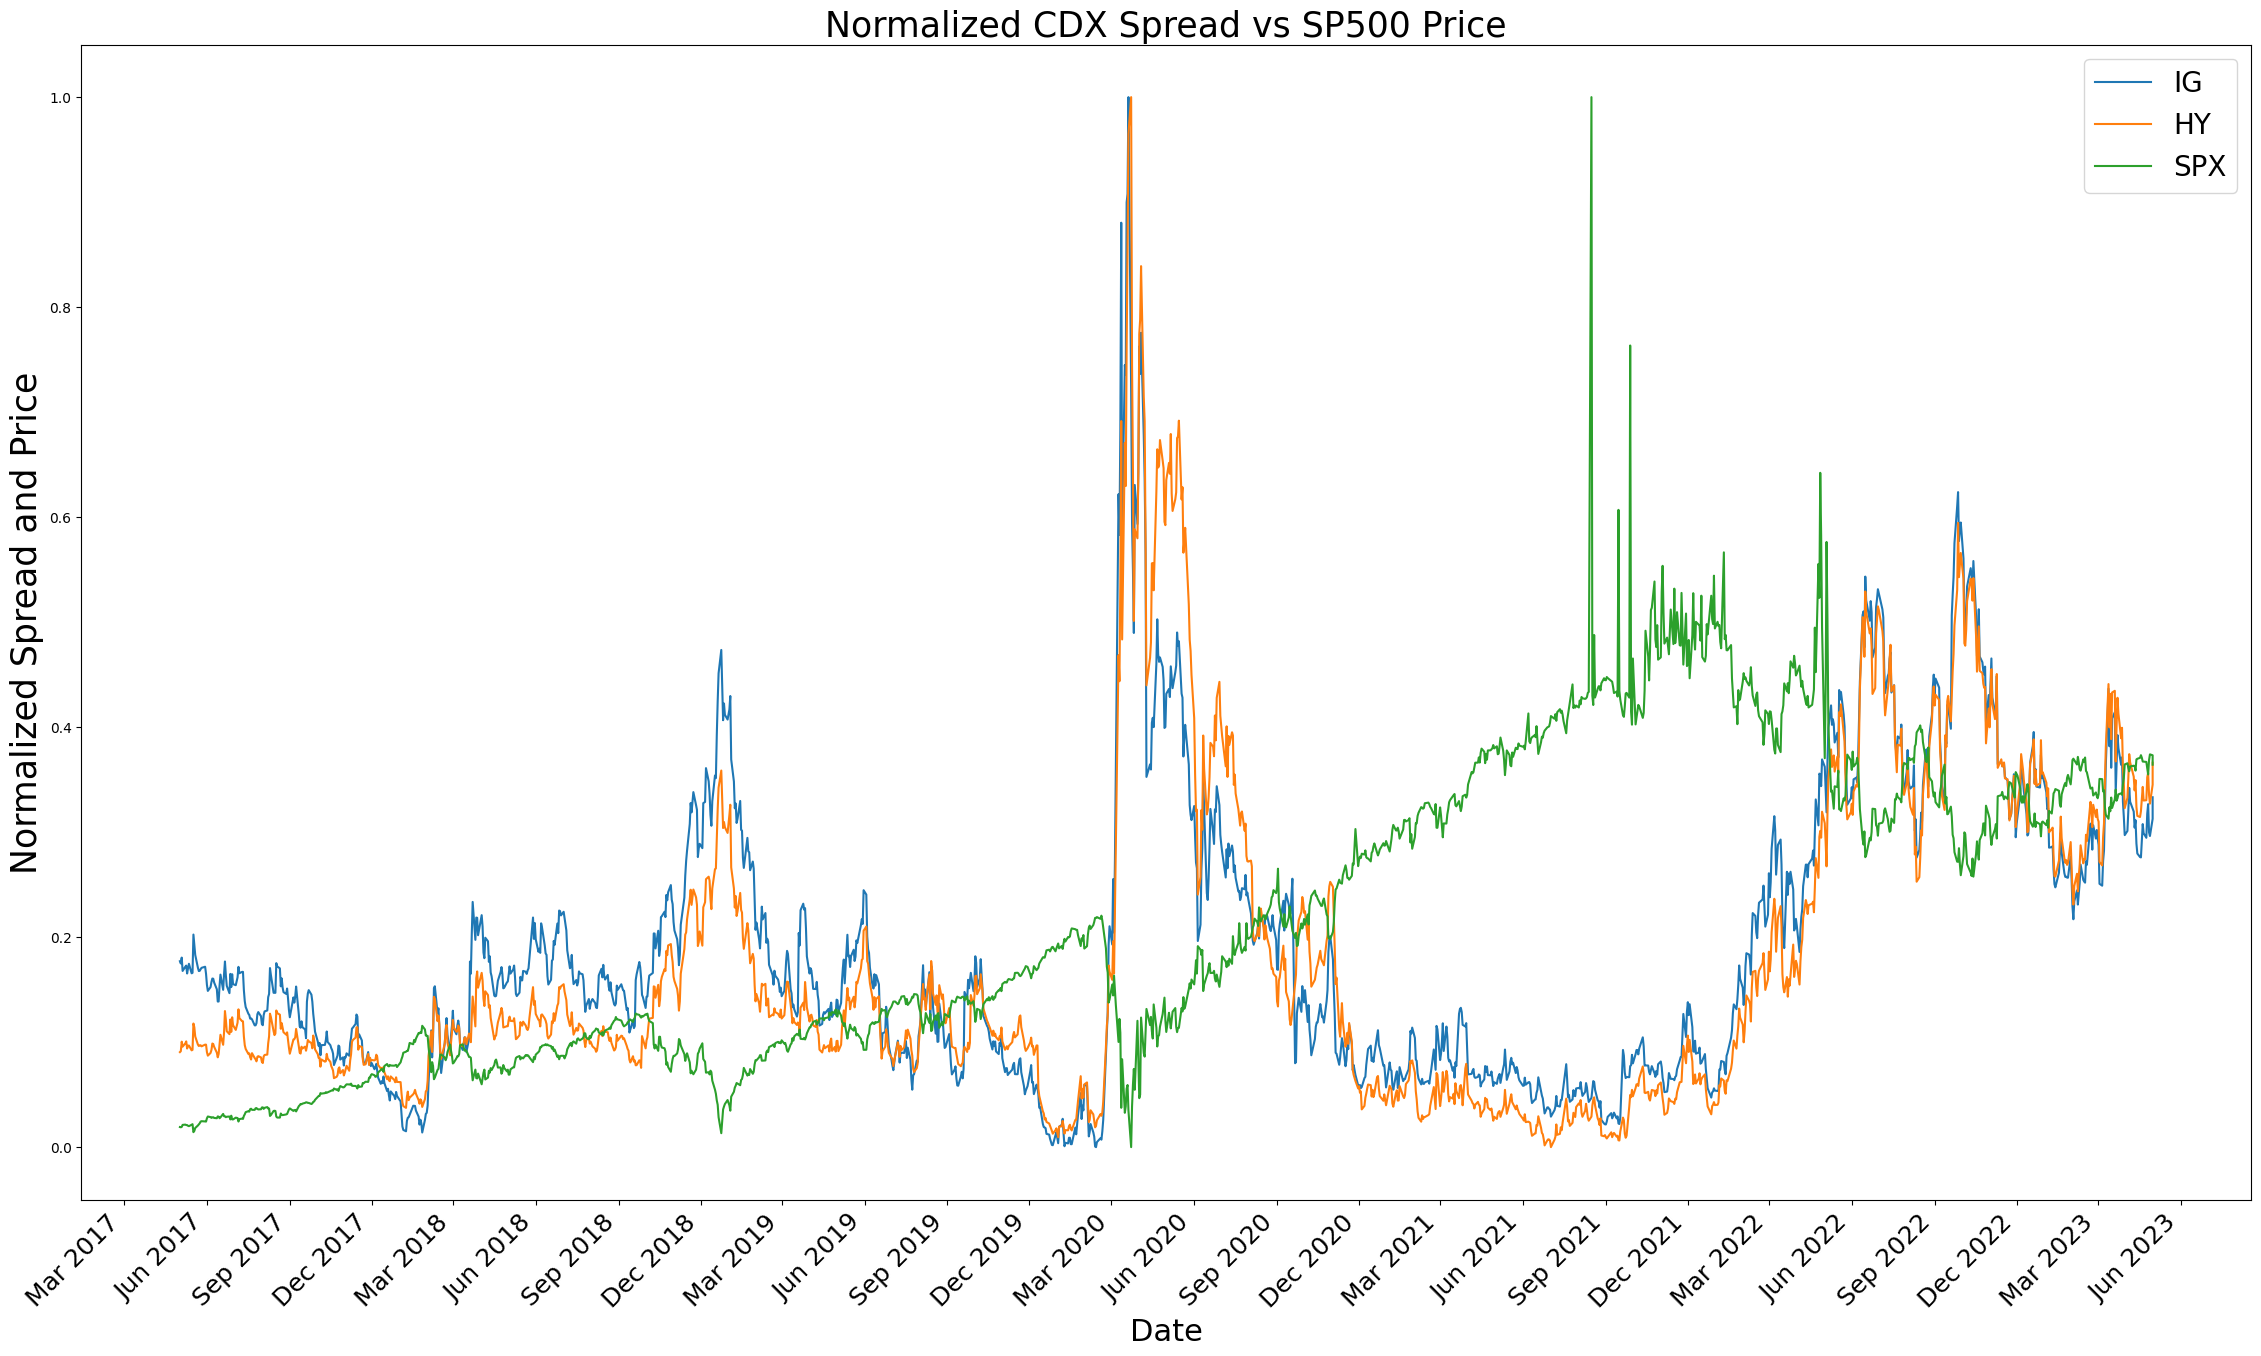

In [4]:
data = ['IG','HY','SPX']
fig, ax = plt.subplots(figsize=(28, 15))
[ax.plot(common_date_dfs[label].index, normalized_series[label], label=label) for label in data]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right',fontsize=18)
plt.xlabel('Date',fontsize = 22)
plt.ylabel('Normalized Spread and Price',fontsize = 25)
plt.title('Normalized CDX Spread vs SP500 Price',fontsize = 25)
plt.legend(fontsize=20)
plt.savefig('normalized_combined')
plt.show()

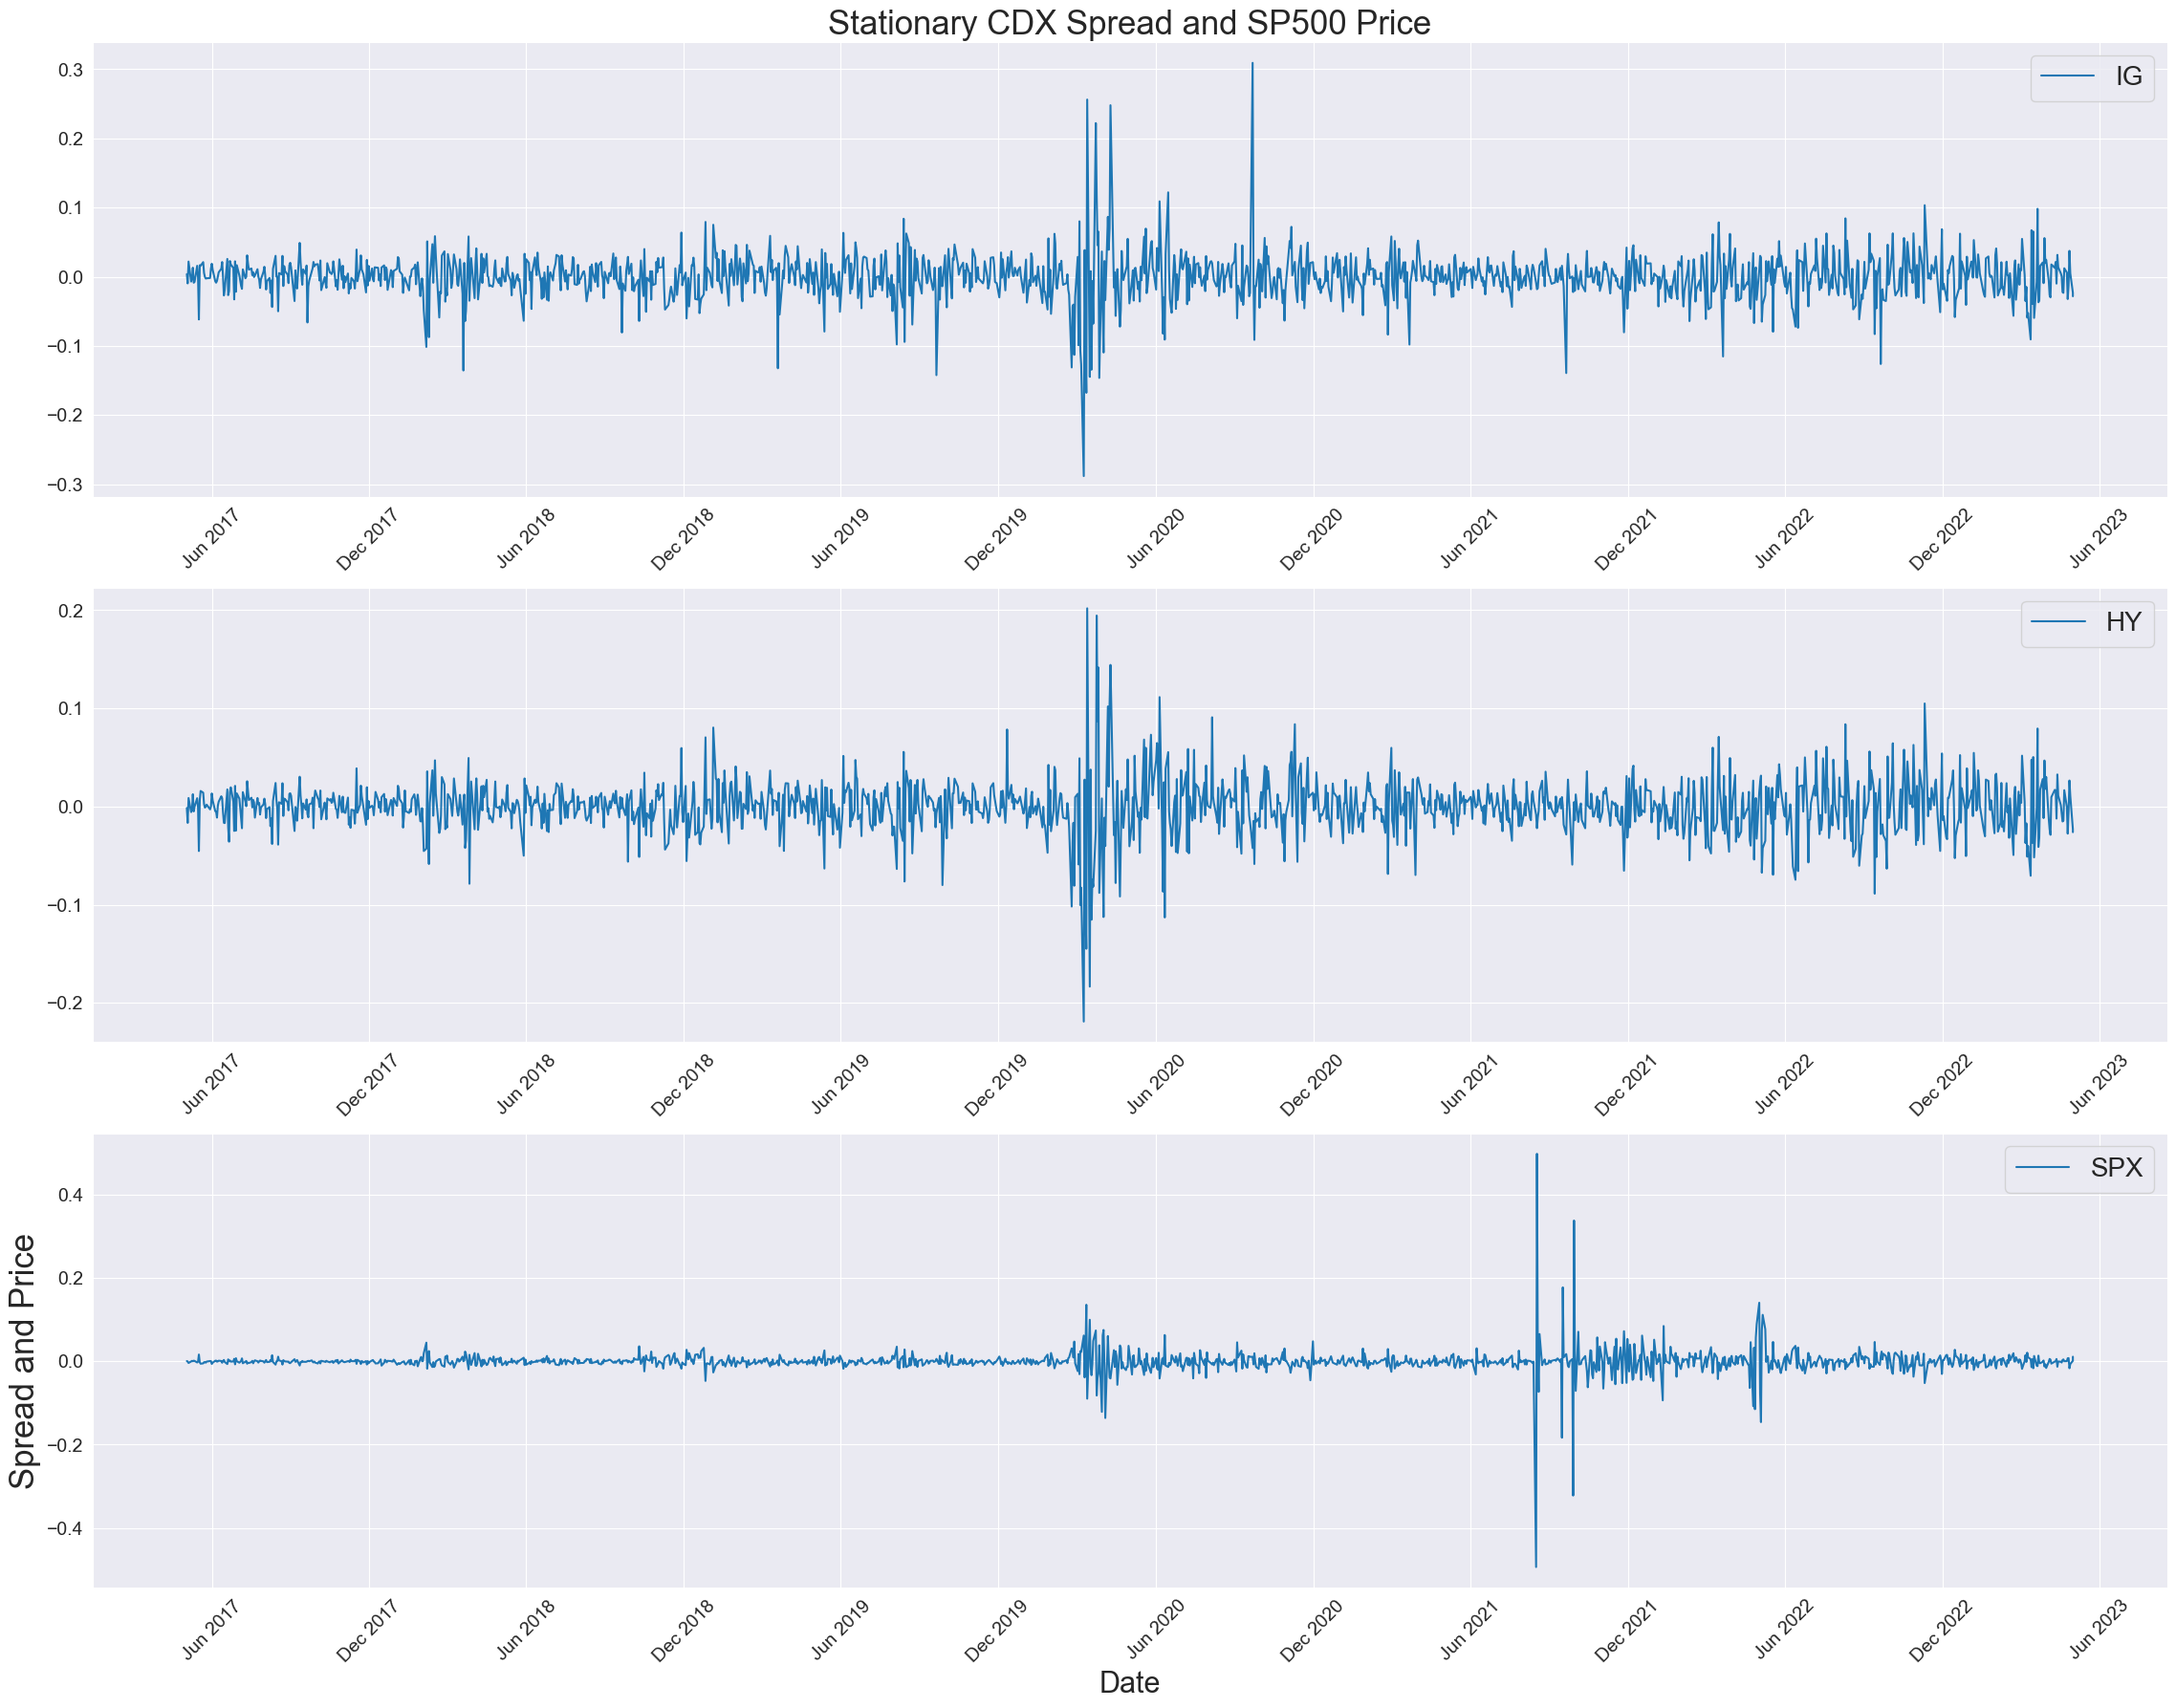

In [24]:
data = ['IG','HY','SPX']
fig, ax = plt.subplots(3,figsize=(28, 21))
for i in range(len(data)):
    ax[i].plot(common_date_dfs[data[i]].index[:-1], stationary_series[data[i]], label=data[i])
    ax[i].xaxis.set_major_locator(MonthLocator(interval=6))
    ax[i].xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax[i].tick_params(axis = 'x',rotation=45,labelsize=14)
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].legend(fontsize=20)
plt.xlabel('Date',fontsize = 22)
plt.ylabel('Spread and Price',fontsize = 25)
ax[0].set_title('Stationary CDX Spread and SP500 Price',fontsize = 25)
plt.savefig("stationary_combined")
plt.show()

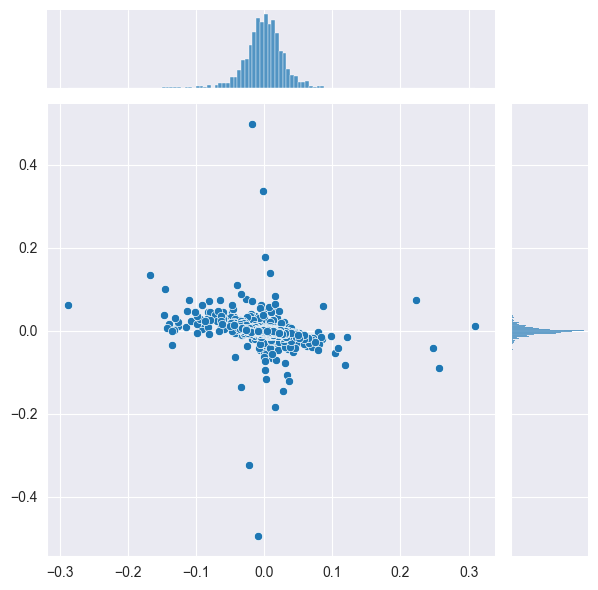

In [26]:
sns.jointplot(x=IG_SPX[:, 0], y=IG_SPX[:, 1], kind="scatter");


In [7]:
max(stationary_series['SPX'])

0.4973044695861031

In [8]:
stats.describe(stationary_series['SPX'])

DescribeResult(nobs=1499, minmax=(-0.49329606138581106, 0.4973044695861031), mean=-0.00036494802249563223, variance=0.0008546599378424881, skewness=0.19749795992413227, kurtosis=133.69400763875893)

In [29]:
filter_cond = np.where(np.abs(stationary_series['SPX'])<0.1)
filtered_stationary_series = {fn :stationary_series[fn][filter_cond] for fn in data}

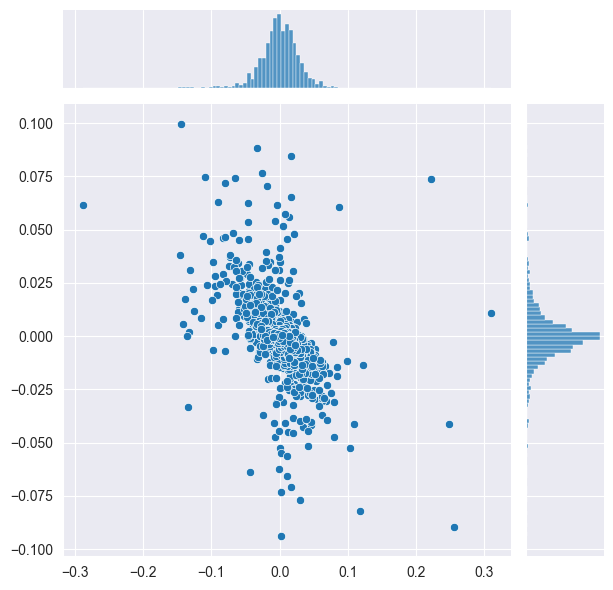

In [30]:
#visualizing filtered series
filtered_IG_SPX = np.stack((filtered_stationary_series['IG'],filtered_stationary_series['SPX']),axis=1)
sns.jointplot(x=filtered_IG_SPX[:, 0], y=filtered_IG_SPX[:, 1], kind="scatter");

In [49]:
def pobs(X):
    # X.shape = (n,d), n = # of samples, d = dimension of data
    n = X.shape[0]
    U = rankdata(X, method='ordinal') / float(n+1)  # divide by n+1 to mitigate boundary errors
    return U

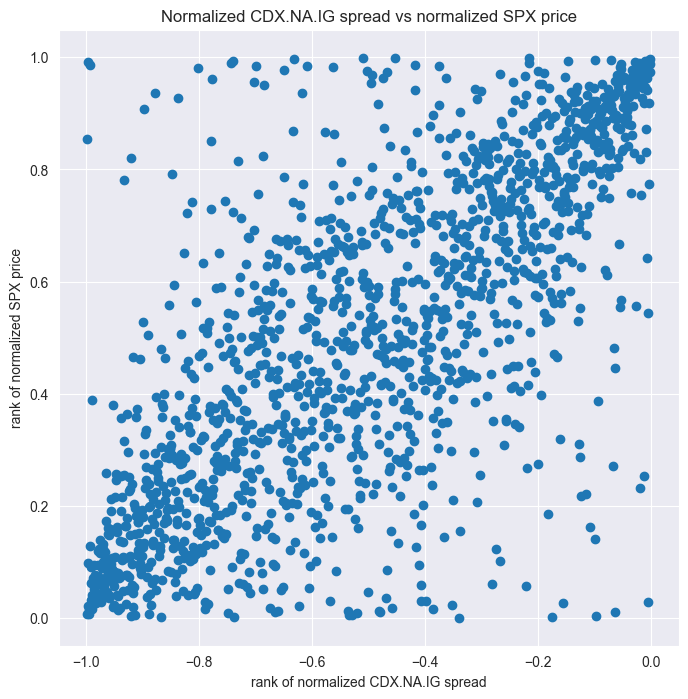

In [69]:
u1=-1*pobs(stationary_series['IG'])
u2 = pobs(stationary_series['SPX'])
plt.scatter(u1,u2)
plt.xlabel("rank of normalized CDX.NA.IG spread")
plt.ylabel("rank of normalized SPX price")
plt.title("Normalized CDX.NA.IG spread vs normalized SPX price")
plt.savefig("normalized_IG_SPX")

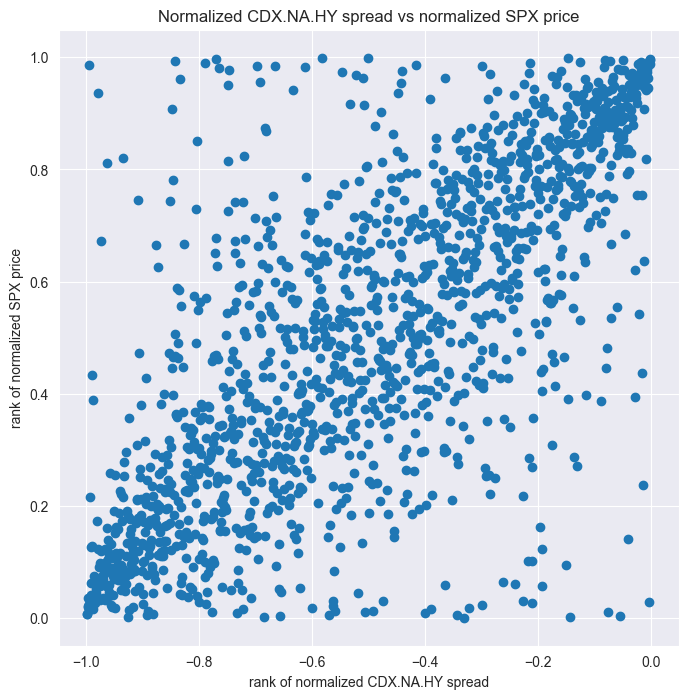

In [71]:
u1=-1*pobs(stationary_series['HY'])
u2 = pobs(stationary_series['SPX'])
plt.scatter(u1,u2)
plt.xlabel("rank of normalized CDX.NA.HY spread")
plt.ylabel("rank of normalized SPX price")
plt.title("Normalized CDX.NA.HY spread vs normalized SPX price")
plt.savefig("normalized_HY_SPX")

In [79]:
#calculating kendall's tau for HY and SPX, and the respective alpha
u1=-1*pobs(stationary_series['HY'])
u2 = pobs(stationary_series['SPX'])
HY_SPX_t = kendalltau(u1,u2)[0]
HY_alpha = 1/(1-HY_SPX_t)
print(HY_alpha)

2.259601915955563


In [80]:
#calculating kendall's tau for IG and SPX, and the respective alpha
u1=-1*pobs(stationary_series['IG'])
u2 = pobs(stationary_series['SPX'])
IG_SPX_t = kendalltau(u1,u2)[0]
IG_alpha = 1/(1-IG_SPX_t)
print(IG_alpha)

2.212779417967103


In [85]:
#gumbel copula with package 
rank = {fn:pobs(stationary_series[fn]) for fn in filenames}
copula = GumbelCopula()

IG_SPX = np.stack((-1*rank['IG'],rank['SPX']),axis=1)
IG_theta = copula.fit_corr_param(IG_SPX)
print(IG_theta)

HY_SPX = np.stack((-1*rank['HY'],rank['SPX']),axis=1)
HY_theta = copula.fit_corr_param(HY_SPX)
print(HY_theta)

2.212779417967103
2.259601915955563


In [87]:
#frank copula with package 

copula = FrankCopula()

IG_theta = copula.fit_corr_param(IG_SPX)
print(IG_theta)

HY_theta = copula.fit_corr_param(HY_SPX)
print(HY_theta)

6.686313711921278
6.8915749982546455


In [88]:
#Clayton copula with package 

copula = ClaytonCopula()

IG_theta = copula.fit_corr_param(IG_SPX)
print(IG_theta)

HY_theta = copula.fit_corr_param(HY_SPX)
print(HY_theta)

2.425558835934206
2.5192038319111254


In [ ]:
#student-t copula with package 

copula = StudentTCopula()


IG_theta = copula.fit_corr_param(IG_SPX)
print(IG_theta)

HY_theta = copula.fit_corr_param(HY_SPX)
print(HY_theta)

In [89]:
copula = StudentTCopula()
copula.fit_corr_param(IG_SPX)

0.7584434855191329